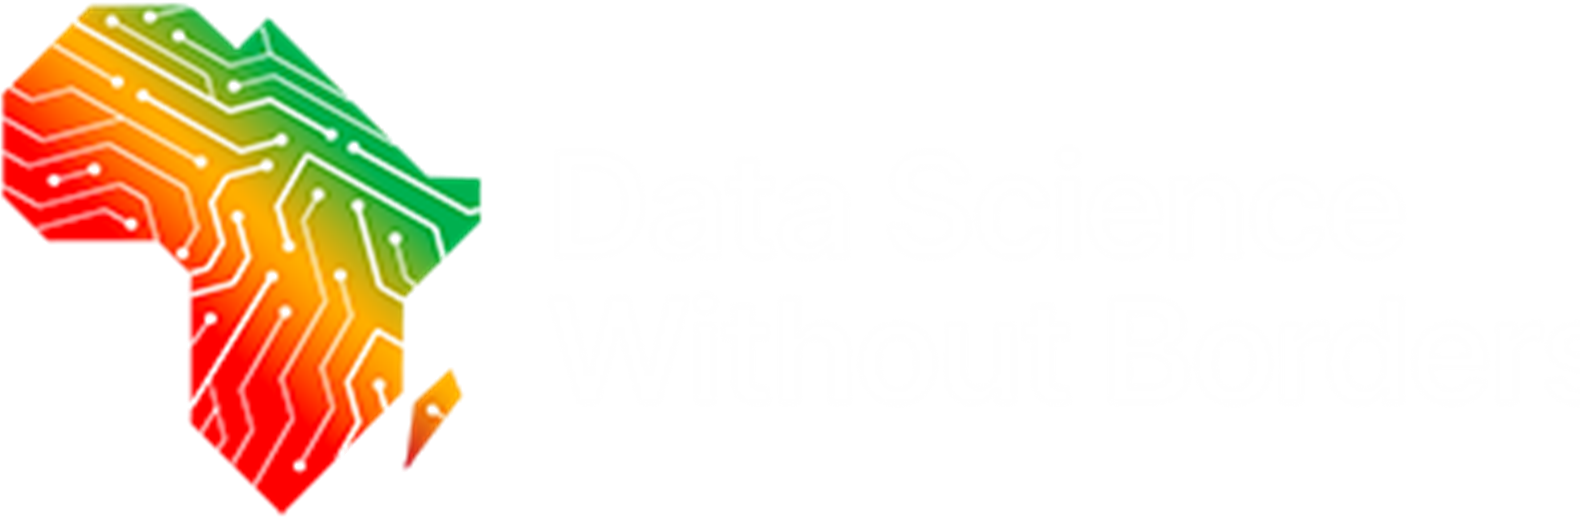

# <span style="color:#f57c00; font-size:32px"><b>🩺 Health Data Anomaly Detection</b></span>

#### <span style="color:#388e3c"><i>Prepared by: Fetlework Gubena and Bezawit Belachew</i></span>

---

### <span style="color:#fbc02d">Functionality Name:</span>
**<span style="color:#f57c00">Health Data Anomaly Detection using LSTM Autoencoder (Streamlit App)</span>**

---

## <span style="color:#388e3c">📌 Description</span>
This submission implements a functional anomaly detection pipeline for health data using an **LSTM Autoencoder**, embedded in an interactive **Streamlit** web app. Users upload a health dataset in CSV format, and the system performs the following steps:

---

## <span style="color:#fbc02d">⚙️ Data Preprocessing</span>
- Features are scaled using **MinMaxScaler**.
- Only **normal samples** (`fetal_health == 1`) are used to train the LSTM Autoencoder.

---

## <span style="color:#f57c00">🧠 Model Training</span>
A custom **LSTM Autoencoder** learns to represent the distribution of the normal class.

---

## <span style="color:#388e3c">📊 Reconstruction Error</span>
- The model attempts to reconstruct all samples.
- **Reconstruction error** is used as an anomaly score.
- Higher error = higher likelihood of being an **anomaly**.

---

## <span style="color:#fbc02d">🧪 Supervised Classification with SMOTE</span>
- The errors are combined with binary labels (0 = normal, 1 = anomaly).
- **SMOTE** is applied to balance the dataset.
- A **Random Forest** classifier is trained to refine anomaly classification.

---

## <span style="color:#f57c00">📈 Performance Evaluation</span>

-  **Classification Report**  
-  **Confusion Matrix**  
-  **ROC Curve**  
-  **Precision-Recall Curve**

---

## <span style="color:#388e3c">🔍 Anomaly Visualization</span>
Detected anomalies are shown in a table with their full feature context.

---

## <span style="color:#fbc02d">✨ Innovation</span>
This app combines **unsupervised deep learning (LSTM autoencoder)** with **supervised refinement (SMOTE + Random Forest)**  tackling real world data issues like **noise**, **imbalance**, and **missing patterns**  while providing a **simple interface** for **non-technical users**.

---

## <span style="color:#f57c00">💡 Why It Matters</span>
Early anomaly detection in health data enables:
- Timely interventions  
- Data quality assurance  
- Patient risk stratification  
- Better decision-making in public health

---

## <span style="color:#388e3c">📦 Future Enhancements</span>
-  Support for **time-series health data**  
-  Model **save/load functionality**  
-  User-defined **anomaly thresholds**  
-  Expand to support **multiple health outcomes** beyond `fetal_health`

---

> <span style="color:#f57c00; font-weight:bold"> Developed for the DSWB Africa Anomaly Detection Hackathon</span>  
> Addressing challenges in data quality, representation, and actionable anomaly discovery in healthcare systems.

---


In [ ]:
# anomaly_detection_streamlit.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# --- Function to define and train an LSTM autoencoder using only normal samples ---
def train_autoencoder(X_train):
    timesteps = X_train.shape[1]      # Number of time steps
    n_features = X_train.shape[2]     # Number of features per time step

    # Define LSTM autoencoder architecture
    inputs = Input(shape=(timesteps, n_features))
    encoded = LSTM(32, activation='relu', return_sequences=False)(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(n_features, activation='sigmoid', return_sequences=True)(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Use early stopping and learning rate reduction to prevent overfitting
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
    ]

    # Train autoencoder on normal samples only
    autoencoder.fit(
        X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=0
    )

    return autoencoder

# --- Streamlit web app interface starts here ---
st.title("Health Data Anomaly Detection App")
st.write("Upload your health dataset as a CSV file to detect anomalies using an LSTM Autoencoder model.")

# Upload a CSV file from the user
uploaded_file = st.file_uploader("Choose a CSV file", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    st.write("### Preview of Uploaded Data:")
    st.dataframe(df.head())

    # Ensure target column exists
    if 'fetal_health' not in df.columns:
        st.error("The dataset must contain a 'fetal_health' column as the target.")
    else:
        # --- Step 1: Data Preprocessing ---
        X = df.drop('fetal_health', axis=1)
        y = df['fetal_health'].apply(lambda x: 0 if x == 1 else 1)  # Normal = 0, Anomaly = 1

        # Scale features between 0 and 1
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # --- Step 2: Use only normal data to train the autoencoder ---
        X_train = X_scaled[y == 0]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Shape for LSTM input

        # --- Step 3: Train the autoencoder ---
        st.write("Training LSTM Autoencoder on normal samples...")
        autoencoder = train_autoencoder(X_train)

        # --- Step 4: Compute reconstruction errors on all data ---
        X_all = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        X_pred = autoencoder.predict(X_all)
        recon_errors = np.mean(np.square(X_all - X_pred), axis=(1, 2))

        # Store reconstruction error and true label
        results_df = pd.DataFrame({
            'reconstruction_error': recon_errors,
            'label': y
        })

        # --- Step 5: Apply SMOTE and train Random Forest classifier ---
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(results_df[['reconstruction_error']], results_df['label'])

        # Fit classifier on oversampled data
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_res, y_res)

        # Make predictions on original data
        y_pred = clf.predict(results_df[['reconstruction_error']])
        y_prob = clf.predict_proba(results_df[['reconstruction_error']])[:, 1]

        # --- Step 6: Show classification metrics ---
        st.write("### Classification Report")
        st.text(classification_report(results_df['label'], y_pred))

        # Confusion Matrix
        cm = confusion_matrix(results_df['label'], y_pred)
        st.write("### Confusion Matrix")
        fig_cm, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        st.pyplot(fig_cm)

        # ROC Curve
        st.write("### ROC Curve")
        fpr, tpr, _ = roc_curve(results_df['label'], y_prob)
        auc = roc_auc_score(results_df['label'], y_prob)
        fig_roc, ax = plt.subplots()
        ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
        st.pyplot(fig_roc)

        # Precision-Recall Curve
        st.write("### Precision-Recall Curve")
        precision, recall, _ = precision_recall_curve(results_df['label'], y_prob)
        fig_pr, ax = plt.subplots()
        ax.plot(recall, precision)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        st.pyplot(fig_pr)

        # --- Step 7: Display Detected Anomalies ---
        df['Anomaly'] = y_pred
        st.write("### Anomalies Detected")
        st.dataframe(df[df['Anomaly'] == 1])
